In [1]:
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import codecs
import json
import itertools
import csv
import math
import matplotlib.pyplot as plt
import string

def read_dataset(path):
  with codecs.open(path, 'r', 'utf-8') as myFile:
    content = myFile.read()
  dataset = json.loads(content)
  return dataset

path = 'data/raw_data.json'
dataset = read_dataset(path)

print 'The dataset contains %d samples.' %(len(dataset))
print 'Available attributes: ', sorted(dataset[0].keys())
print 'First post:'
print json.dumps(dataset[0], sort_keys=True, indent=2)

successes = [r['requester_received_pizza'] for r in dataset]
success_rate = 100.0 * sum(successes) / float(len(successes))
print 'The average success rate is: %.2f%%' %(success_rate)


The dataset contains 5671 samples.
Available attributes:  [u'giver_username_if_known', u'in_test_set', u'number_of_downvotes_of_request_at_retrieval', u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited', u'request_id', u'request_number_of_comments_at_retrieval', u'request_text', u'request_text_edit_aware', u'request_title', u'requester_account_age_in_days_at_request', u'requester_account_age_in_days_at_retrieval', u'requester_days_since_first_post_on_raop_at_request', u'requester_days_since_first_post_on_raop_at_retrieval', u'requester_number_of_comments_at_request', u'requester_number_of_comments_at_retrieval', u'requester_number_of_comments_in_raop_at_request', u'requester_number_of_comments_in_raop_at_retrieval', u'requester_number_of_posts_at_request', u'requester_number_of_posts_at_retrieval', u'requester_number_of_posts_on_raop_at_request', u'requester_number_of_posts_on_raop_at_retrieval', u'requester_number_of_subreddits_at_request', u'requester_received_pizza', u'

In [2]:
#read train data
def create_data_sets(dataset):
    
    train = []
    cv = []
    test = []
    current = 0
    
    shuffle = np.random.permutation(np.arange(len(dataset)))
    
    train_range = int(round(len(shuffle) * 0.6))
    cv_range = int(round(len(shuffle) * 0.2))
    test_range = len(dataset) - train_range - cv_range
    
    for i in range(train_range):
        train.append(dataset[shuffle[current]])
        current += 1

    for i in range(cv_range):
        cv.append(dataset[shuffle[current]])
        current += 1

    for i in range(test_range):
        test.append(dataset[shuffle[current]])
        current += 1

    train_labels = np.zeros(len(train))
    cv_labels = np.zeros(len(cv))
    test_labels = np.zeros(len(test))

    train_data_text = []
    cv_data_text = []
    test_data_text = []

    for i in range(len(train_labels)):
        train_labels[i] = train[i].get('requester_received_pizza')

    for i in range(len(cv_labels)):
        cv_labels[i] = cv[i].get('requester_received_pizza')

    for i in range(len(test_labels)):
        test_labels[i] = test[i].get('requester_received_pizza')

    return train, train_labels, cv, cv_labels, test, test_labels

train, train_labels, cv, cv_labels, test, test_labels = create_data_sets(dataset)

In [3]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
def better_preprocessor(s):
### STUDENT START ###
    
    #LOWERCASE
    s = s.lower()
    
    #REMOVE PUNCTUATION
    s = s.replace("!","")
    s = s.replace(",","")
    s = s.replace("?","")
    s = s.replace(".","")
    s = s.replace("\'","")
    s = s.replace("-","")
    s = s.replace("_","")
    s = s.replace("*","")
    s = s.replace("&","")
    s = s.replace("$","")
    s = s.replace("#","")
    s = s.replace("~","")
    s = s.replace("\\","")
    s = s.replace("/","")
    s = s.replace("+","")
    s = s.replace("=","")
    s = s.replace("<","")
    s = s.replace(">","")
    s = s.replace(";","")
    s = s.replace(":","")
    s = s.replace("\"","")
    
    #change any number to the $ symbol
    s = s.replace("0","$")
    s = s.replace("1","$")
    s = s.replace("2","$")
    s = s.replace("3","$")
    s = s.replace("4","$")
    s = s.replace("5","$")
    s = s.replace("6","$")
    s = s.replace("7","$")
    s = s.replace("8","$")
    s = s.replace("9","$")
    
    #rescan tmp and change sequences of $$ into a single $
    while(s.find("$$") != -1):
        s = s.replace("$$","$")
        
    return s

Finding the optimal model fails for the most part because best is determined by score which isn't the F1Score :(

In [4]:
#create upsample for the positive case

def upsample_50_50(dataset, train_labels, cv_labels, test_labels):
    
    class_ratio = 1 / ((sum(train_labels) + sum(cv_labels) +sum(test_labels)) / len(dataset))
    
    minority_count = ((sum(train_labels) + sum(cv_labels) +sum(test_labels)))
    minority_goal = minority_count * (class_ratio - 1)
    
    upsampled_dataset = list(dataset)
                      
    while minority_count < minority_goal:
        index = int(round(np.random.rand()*len(dataset))) - 1
        
        if dataset[index].get('requester_received_pizza') == 1:
            upsampled_dataset.append(dataset[index])
            minority_count += 1
        
    return upsampled_dataset
                      
upsampled_dataset = upsample_50_50(dataset, train_labels, cv_labels, test_labels)

train_up, train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels = create_data_sets(upsampled_dataset)


In [5]:
import string

def make_subreddits_matrix(upsampled_dataset, train_up, cv_up, test_up, ngram_range=(1, 1)):
    total_data_text = []
    train_data_text = []
    cv_data_text = []
    test_data_text = []

    feature = 'requester_subreddits_at_request'
    
    for i in range(len(upsampled_dataset)):
        total_data_text.append(string.join(upsampled_dataset[i].get(feature)," "))

    for i in range(len(train_up)):
        train_data_text.append(string.join(train_up[i].get(feature)," "))

    for i in range(len(cv_up)):
        cv_data_text.append(string.join(cv_up[i].get(feature)," "))

    for i in range(len(test_up)):
        test_data_text.append(string.join(test_up[i].get(feature)," "))

    vec_total = CountVectorizer(preprocessor=better_preprocessor, analyzer='word',tokenizer=LemmaTokenizer())
    tokenized_total_data = vec_total.fit_transform(train_data_text)

    vec_train = CountVectorizer(vocabulary=vec_total.vocabulary_,
                                preprocessor=better_preprocessor, 
                                analyzer='word', 
                                ngram_range=ngram_range, 
                                tokenizer=LemmaTokenizer())
    tokenized_train_data = vec_train.fit_transform(train_data_text)

    vec_cv = CountVectorizer(vocabulary=vec_total.vocabulary_,
                             preprocessor=better_preprocessor, 
                             ngram_range=ngram_range,
                             analyzer='word',
                             tokenizer=LemmaTokenizer())
    tokenized_cv_data = vec_cv.fit_transform(cv_data_text)

    vec_test = CountVectorizer(vocabulary=vec_total.vocabulary_,
                               preprocessor=better_preprocessor, 
                               ngram_range=ngram_range,
                               analyzer='word',
                               tokenizer=LemmaTokenizer())
    tokenized_test_data = vec_test.fit_transform(test_data_text)
    
    return vec_total.vocabulary_, tokenized_train_data.todense(), tokenized_cv_data.todense(), tokenized_test_data.todense()

vocab_sr, train_data_text_sr, cv_data_text_sr, test_data_text_sr = make_subreddits_matrix(
                                                                    upsampled_dataset, train_up, cv_up, test_up)


For feature request_text_edit_aware



The stats for C=0.25
(1, 12633)
L2 Total :12633
L2 Number non-zero :12633
L2 Number features with all zero :0
(1, 12633)
L1 Total :12633
L1 Number non-zero :514
L1 Number features with all zero :12119
             precision    recall  f1-score   support

        0.0       0.66      0.67      0.66       895
        1.0       0.63      0.62      0.62       815

avg / total       0.64      0.65      0.64      1710


The stats for C=0.5
(1, 12633)
L2 Total :12633
L2 Number non-zero :12633
L2 Number features with all zero :0
(1, 12633)
L1 Total :12633
L1 Number non-zero :967
L1 Number features with all zero :11666
             precision    recall  f1-score   support

        0.0       0.73      0.68      0.71       895
        1.0       0.67      0.72      0.70       815

avg / total       0.70      0.70      0.70      1710


The stats for C=1
(1, 12633)
L2 Total :12633
L2 Number non-zero :12633
L2 Number features with all zero :0
(1, 12633)
L1 Total :

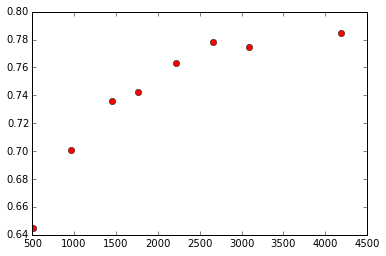

For feature request_title



The stats for C=0.25
(1, 4486)
L2 Total :4486
L2 Number non-zero :4486
L2 Number features with all zero :0
(1, 4486)
L1 Total :4486
L1 Number non-zero :194
L1 Number features with all zero :4292
             precision    recall  f1-score   support

        0.0       0.61      0.57      0.59       895
        1.0       0.56      0.60      0.58       815

avg / total       0.59      0.58      0.59      1710


The stats for C=0.5
(1, 4486)
L2 Total :4486
L2 Number non-zero :4486
L2 Number features with all zero :0
(1, 4486)
L1 Total :4486
L1 Number non-zero :460
L1 Number features with all zero :4026
             precision    recall  f1-score   support

        0.0       0.65      0.61      0.63       895
        1.0       0.60      0.64      0.62       815

avg / total       0.62      0.62      0.62      1710


The stats for C=1
(1, 4486)
L2 Total :4486
L2 Number non-zero :4486
L2 Number features with all zero :0
(1, 4486)
L1 Total :4486
L1 Number non-zero :9

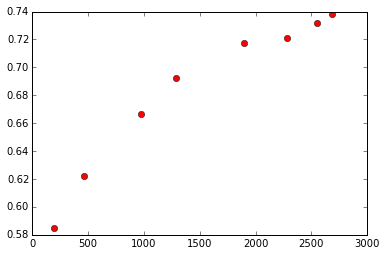

For feature requester_subreddits_at_request



The stats for C=0.25
(1, 7084)
L2 Total :7084
L2 Number non-zero :7084
L2 Number features with all zero :0
(1, 7084)
L1 Total :7084
L1 Number non-zero :208
L1 Number features with all zero :6876
             precision    recall  f1-score   support

        0.0       0.61      0.69      0.65       895
        1.0       0.60      0.52      0.56       815

avg / total       0.61      0.61      0.61      1710


The stats for C=0.5
(1, 7084)
L2 Total :7084
L2 Number non-zero :7084
L2 Number features with all zero :0
(1, 7084)
L1 Total :7084
L1 Number non-zero :501
L1 Number features with all zero :6583
             precision    recall  f1-score   support

        0.0       0.63      0.69      0.66       895
        1.0       0.62      0.55      0.58       815

avg / total       0.62      0.62      0.62      1710


The stats for C=1
(1, 7084)
L2 Total :7084
L2 Number non-zero :7084
L2 Number features with all zero :0
(1, 7084)
L1 Total :7084
L1 

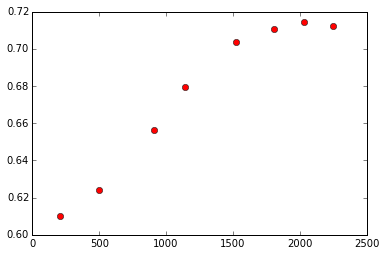

In [9]:
def L1PruneText(train, train_labels, cv, cv_labels, feature, ngram_range=(1,1)):
   
    C_val = [0.25, 0.5, 1, 1.5, 3, 6,12, 24]
    accuracy = []  #store accuracies for plotting
    NNZ_array = [] #store non-zero for plotting
    
    train_data_text = []
    cv_data_text = []
    
    Valuable_Vocab_List = []

    print "For feature " + feature + "\n\n"
    
    if feature == 'requester_subreddits_at_request':
        for i in range(len(train)):
            train_data_text.append(string.join(train[i].get(feature)," "))
        for i in range(len(cv)):
            cv_data_text.append(string.join(cv[i].get(feature)," "))
    else:
        for i in range(len(train)):
            train_data_text.append(train[i].get(feature))
        for i in range(len(cv)):
            cv_data_text.append(cv[i].get(feature))
    
    #Iterate through various C_val parameters for L2 and L1 norms
    
    for iter in range(len(C_val)):

        print "\nThe stats for C=" + str(C_val[iter])
        
        ############### L2 NORM COMPUTATION #####################
        countVecPreProc = CountVectorizer(preprocessor=better_preprocessor,
                                          ngram_range=ngram_range)
        DocMatrixPreProc = countVecPreProc.fit_transform(train_data_text)
        LRPreProcL2 = LogisticRegression(C=C_val[iter],penalty='l2',tol = 0.01)
        LRPreProcL2.fit(DocMatrixPreProc,train_labels)

        numNonZero = 0  #sum of nonzero parameters for all classes
        allZero = 0     #all are 0 for this feature for all classes
        total_param = 0       #number of parameters

        print LRPreProcL2.coef_.shape

        for i in range(LRPreProcL2.coef_.shape[0]):
            for j in range(LRPreProcL2.coef_.shape[1]):
                total_param = total_param + 1
                if(LRPreProcL2.coef_[i,j]!=0):
                    numNonZero = numNonZero + 1

                #see if all of this feature are 0
                if((LRPreProcL2.coef_[0,j] == 0)):
                    allZero = allZero + 1

        print "L2 Total :" + str(total_param)
        print "L2 Number non-zero :" + str(numNonZero)
        print "L2 Number features with all zero :" + str(allZero)

        ############### L1 NORM COMPUTATION #####################
        countVecPreProc = CountVectorizer(preprocessor=better_preprocessor,
                                          ngram_range=ngram_range)
        DocMatrixPreProc = countVecPreProc.fit_transform(train_data_text)
        LRPreProcL1 = LogisticRegression(C=C_val[iter],penalty='l1',tol = 0.01)
        LRPreProcL1.fit(DocMatrixPreProc,train_labels)

        numNonZero = 0  #sum of nonzero parameters for all classes
        allZero = 0     #all are 0 for this feature for all classes
        total_param = 0       #number of parameters
        ValuableIndices = [] #track features that have at least one class with a non zero weight

        print LRPreProcL1.coef_.shape

        for i in range(LRPreProcL1.coef_.shape[0]):
            for j in range(LRPreProcL1.coef_.shape[1]):
                total_param = total_param + 1
                if(LRPreProcL1.coef_[i,j]!=0):
                    numNonZero = numNonZero + 1

                #see if all of this feature are 0
                if((LRPreProcL1.coef_[0,j] == 0)):
                    allZero = allZero + 1
                else:
                    ValuableIndices.append(j)

        print "L1 Total :" + str(total_param)
        print "L1 Number non-zero :" + str(numNonZero)
        print "L1 Number features with all zero :" + str(allZero)
        
        ############### FILTER USING L1 WEIGHTS #####################
        #get valuable vocab using the criteria L1 weight > 0

        ValuableVocab = []

        for i in range(LRPreProcL1.coef_.shape[1]):
            if i in ValuableIndices:
                ValuableVocab.append(countVecPreProc.get_feature_names()[i])

        #Trim vocab to just valuable features
        countVecL1Trim = CountVectorizer(vocabulary = ValuableVocab, 
                                         preprocessor=better_preprocessor,
                                         ngram_range=ngram_range)
        DocMatrixL1Trim = countVecL1Trim.fit_transform(train_data_text)
        LRL1TrimL2Train = LogisticRegression(C=C_val[iter],penalty='l2',tol = 0.01)
        LRL1TrimL2Train.fit(DocMatrixL1Trim,train_labels)


        #make sure we use the vocab from the train data
        countVecDevL1Trim = CountVectorizer(vocabulary = ValuableVocab, 
                                            preprocessor=better_preprocessor,
                                            ngram_range=ngram_range)
        DocMatrixDevL1Trim = countVecDevL1Trim.fit_transform(cv_data_text)
        cv_pred_LR_L1TrimL2Train = LRL1TrimL2Train.predict(DocMatrixDevL1Trim)


        print(classification_report(cv_labels, cv_pred_LR_L1TrimL2Train))
        accuracy.append(LRL1TrimL2Train.score(DocMatrixDevL1Trim,cv_labels))
        NNZ_array.append(numNonZero)
    
        Valuable_Vocab_List.append(ValuableVocab)
    
    plt.plot(NNZ_array,accuracy,'ro')
    plt.show()
    
    return Valuable_Vocab_List

ValuableVocab_Text = L1PruneText(train_up, train_up_labels, cv_up, cv_up_labels, 'request_text_edit_aware')
ValuableVocab_Title = L1PruneText(train_up, train_up_labels, cv_up, cv_up_labels, 'request_title')
ValuableVocab_Subreddits = L1PruneText(train_up, train_up_labels, cv_up, cv_up_labels, 'requester_subreddits_at_request')

In [132]:
def evaluate(train_data, train_labels, 
             cv_data, cv_labels,
             test_data, test_labels,              
             curr_predictor=None,
             best_score=None,
             best_predictor=None,
             print_results=False):    
    
    tmp_predictor = curr_predictor 
    
    curr_predictor.fit(train_data,train_labels)
    cv_pred = curr_predictor.predict(cv_data)    
    test_pred = curr_predictor.predict(test_data)
    if print_results:
        print "\nThe cv stats:\n"
        print(classification_report(cv_labels, cv_pred))
        
        print "The test results are:\n"
        print(classification_report(test_labels, test_pred))
        
    curr_score = curr_predictor.score(test_data,test_labels)
    if curr_score > best_score:
        best_score = curr_score
        best_predictor = tmp_predictor
    
    return best_score, best_predictor, curr_score

In [112]:
def find_optim_model_textual(train, train_labels, cv, cv_labels, test, test_labels, feature, vocab, print_results=False):
    # This function finds the optimal classifier for each class (i.e. LR, KNN, BNB, and DT) and a set of 
    # configuration values (i.e. C for LR, n_neighbors for KNN, alpha for BNB, and max_depth for DT) by 
    # iterating through an array of config values and finding the optimal accuracy in the test data.
    
    # get the texts
    train_data_text = []
    cv_data_text = []
    test_data_text = []
    if feature == 'requester_subreddits_at_request':
        for i in range(len(train_labels)):
            train_data_text.append(string.join(train[i].get(feature)," "))
        for i in range(len(cv_labels)):
            cv_data_text.append(string.join(cv[i].get(feature)," "))
        for i in range(len(test_labels)):
            test_data_text.append(string.join(test[i].get(feature)," "))
    else:
        for i in range(len(train_labels)):
            train_data_text.append(train[i].get(feature))
        for i in range(len(cv_labels)):
            cv_data_text.append(cv[i].get(feature))
        for i in range(len(test_labels)):
            test_data_text.append(test[i].get(feature))
            
    accuracy_LR = []
    accuracy_BNB = []
    accuracy_KNN = []
    accuracy_DT = []
    numVocab = []
    
    # iterate through all vocabulary sizes
    for j in range(len(vocab)):
        numVocab.append(len(vocab[j]))
        vec_train = CountVectorizer(vocabulary=vocab[j],preprocessor=better_preprocessor)
        tokenized_train_data = vec_train.fit_transform(train_data_text)

        vec_cv = CountVectorizer(vocabulary=vocab[j],preprocessor=better_preprocessor)
        tokenized_cv_data = vec_cv.fit_transform(cv_data_text)

        vec_test = CountVectorizer(vocabulary=vocab[j],preprocessor=better_preprocessor)
        tokenized_test_data = vec_test.fit_transform(test_data_text)

        # for each given vocabulary, iterate through all possible Cs
        C_val = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8, 16]                
        best_models= {'LR':None, 'KNN':None, 'BNB':None, 'DT':None}
        best_scores = {'LR':0, 'KNN':0, 'BNB':0, 'DT':0}
        
        for i in range(len(C_val)):            
            best_scores['LR'], best_models['LR'], _ = evaluate(tokenized_train_data, 
                                                            train_labels, 
                                                            tokenized_cv_data,
                                                            cv_labels,
                                                            tokenized_test_data,
                                                            test_labels,                                                             
                                                            curr_predictor=LogisticRegression(C=C_val[i]),
                                                            best_score=best_scores['LR'],
                                                            best_predictor=best_models['LR'],
                                                            print_results=print_results)

            #Bernoulli Naive Bayes section
            if C_val[i] <= 1:
                best_scores['BNB'], best_models['BNB'], _ = evaluate(tokenized_train_data, 
                                                                train_labels, 
                                                                tokenized_cv_data,
                                                                cv_labels,
                                                                tokenized_test_data,
                                                                test_labels,                                                             
                                                                curr_predictor=BernoulliNB(alpha=C_val[i]),
                                                                best_score=best_scores['BNB'],
                                                                best_predictor=best_models['BNB'],
                                                                print_results=print_results)                

            #KNN section
            if C_val[i] >= 1:
                best_scores['KNN'], best_models['KNN'], _ = evaluate(tokenized_train_data, 
                                                                train_labels, 
                                                                tokenized_cv_data,
                                                                cv_labels,
                                                                tokenized_test_data,
                                                                test_labels,                                                             
                                                                curr_predictor=KNeighborsClassifier(n_neighbors=int(C_val[i])),
                                                                best_score=best_scores['KNN'],
                                                                best_predictor=best_models['KNN'],
                                                                 print_results=print_results)  

            #DT section
            if C_val[i] >= 1:
                best_scores['DT'], best_models['DT'], _ = evaluate(tokenized_train_data, 
                                                                train_labels, 
                                                                tokenized_cv_data,
                                                                cv_labels,
                                                                tokenized_test_data,
                                                                test_labels,                                                             
                                                                curr_predictor=DecisionTreeClassifier(max_depth=int(C_val[i])),
                                                                best_score=best_scores['DT'],
                                                                best_predictor=best_models['DT'],
                                                                print_results=print_results) 
                        
        accuracy_LR.append(best_scores['LR'])
        accuracy_BNB.append(best_scores['BNB'])
        accuracy_KNN.append(best_scores['KNN'])
        accuracy_DT.append(best_scores['DT'])
    
    plt.figure(figsize=(10, 5))
    plt.plot(numVocab,accuracy_LR,'y-')
    plt.plot(numVocab,accuracy_BNB,'b-')
    plt.plot(numVocab,accuracy_KNN,'g-')
    plt.plot(numVocab,accuracy_DT,'r-')
    plt.legend(['LR', 'BNB', 'KNN', 'DT'])
    plt.xlabel('Number of vocabularies')
    plt.ylabel('Best accuracy over all configs')
    plt.show()
    
    return tokenized_train_data.todense(), tokenized_cv_data.todense(), tokenized_test_data.todense(), best_models

requester_subreddits_at_request



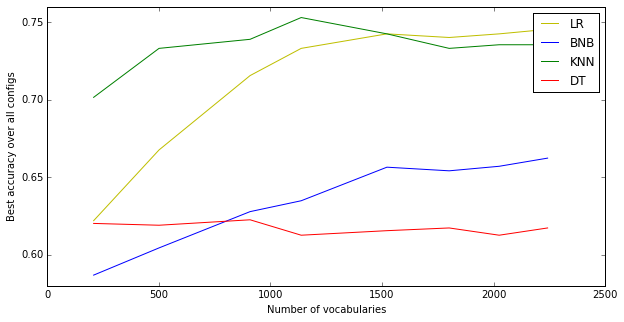

In [126]:
feature = 'requester_subreddits_at_request'
print feature + "\n"
train_data_sr, cv_data_sr, test_data_sr, best_models_sr = find_optim_model_textual(train_up, 
                    train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels, feature,ValuableVocab_Subreddits)

request_text_edit_aware



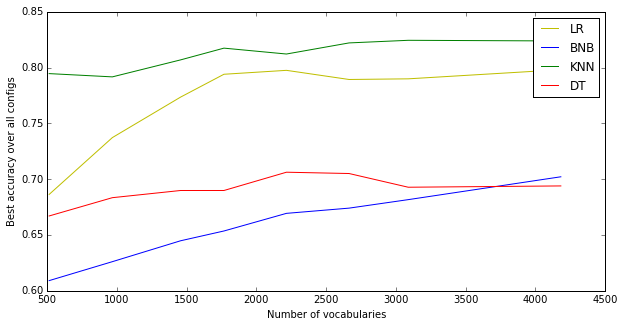

In [114]:
feature = 'request_text_edit_aware'
print feature + "\n"
train_data_text, cv_data_text, test_data_text, best_models_text = find_optim_model_textual(train_up, 
                    train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels, feature, ValuableVocab_Text)

request_title



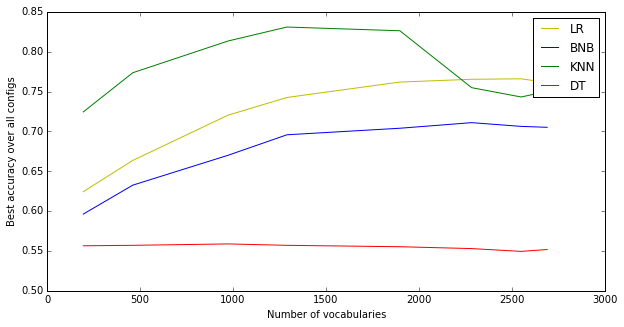

In [128]:
feature = 'request_title'
print feature + "\n"
train_data_title, cv_data_title, test_data_title, best_models_title = find_optim_model_textual(train_up, 
                    train_up_labels, cv_up, cv_up_labels, test_up, test_up_labels, feature, ValuableVocab_Title)

From the information above, we conclude that we should:
* Use KNN or LR for **requester_subreddits_at_request**, with a vocabulary of 1500 ~ 2000
* Use KNN for **request_text_edit_aware**, and the performance plateaus from 3000 vocabularies
* Use KNN for **request_title** with between 1500 and 2000 vocabularies

## Next, we will look at numerical features

First, some helper functions.

In [133]:
def find_optim_model_numerical(train, train_labels, cv, cv_labels, test, test_labels, print_results=False):
    # This function finds the optimal classifier for each class (i.e. LR, KNN, GNB, and DT) and a set of 
    # configuration values (i.e. C for LR, n_neighbors for KNN, and max_depth for DT) by 
    # iterating through an array of config values and finding the optimal accuracy in the test data.
    
    # This function also output the best score and best classifier out of the four classes for later use.
            
    accuracy_LR = []
    config_LR = []
    accuracy_GNB = []
    config_GNB = []
    accuracy_KNN = []
    config_KNN = []
    accuracy_DT = []
    config_DT = []
    best_clf = []
    best_config = 0
    best_score = 0
    
    best_models = dict(LR=None, GNB=None, KNN=None, DT=None)
    best_scores = dict(LR=0, GNB=0, KNN=0, DT=0)  
    
    # iterate through all possible Cs
    C_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8, 16, 25, 50]
    for i in range(len(C_val)):

        #Logistic Regression section
        best_scores['LR'], best_models['LR'], lr_score = evaluate(train, train_labels, 
                                                            cv, cv_labels,
                                                            test, test_labels,                                                             
                                                            curr_predictor=LogisticRegression(C=C_val[i]),
                                                            best_score=best_scores['LR'],
                                                            best_predictor=best_models['LR'],
                                                            print_results=print_results)
        
        config_LR.append(C_val[i])
        accuracy_LR.append(lr_score)
        if best_score < best_scores['LR']:
            best_clf = best_models['LR']
            best_config = C_val[i]
            best_score = best_scores['LR']
        
        
        #Gaussian Naive Bayes section
        best_scores['GNB'], best_models['GNB'], gnb_score = evaluate(train, train_labels, 
                                                            cv, cv_labels,
                                                            test, test_labels,                                                             
                                                            curr_predictor=GaussianNB(),
                                                            best_score=best_scores['GNB'],
                                                            best_predictor=best_models['GNB'],
                                                            print_results=print_results)
        
        config_GNB.append(C_val[i])
        accuracy_GNB.append(gnb_score)
        if best_score < best_scores['GNB']:
            best_clf = best_models['GNB']
            best_config = C_val[i]
            best_score = best_scores['GNB']
            
        #KNN section
        best_scores['KNN'], best_models['KNN'], knn_score = evaluate(train, train_labels, 
                                                            cv, cv_labels,
                                                            test, test_labels,                                                             
                                                            curr_predictor=KNeighborsClassifier(n_neighbors=int(math.ceil(C_val[i] * 2))),
                                                            best_score=best_scores['KNN'],
                                                            best_predictor=best_models['KNN'],
                                                            print_results=print_results)
        config_KNN.append(int(math.ceil(C_val[i] * 2)))
        accuracy_KNN.append(knn_score)
        if best_score < best_scores['KNN']:
            best_clf = best_models['KNN']
            best_config = best_models['KNN'].n_neighbors
            best_score = best_scores['KNN']
            
        #DT section
        best_scores['DT'], best_models['DT'], dt_score = evaluate(train, train_labels, 
                                                            cv, cv_labels,
                                                            test, test_labels,                                                             
                                                            curr_predictor=DecisionTreeClassifier(max_depth=int(math.ceil(C_val[i] * 2))),
                                                            best_score=best_scores['DT'],
                                                            best_predictor=best_models['DT'],
                                                            print_results=print_results)
        
        accuracy_DT.append(dt_score)
        config_DT.append(int(math.ceil(C_val[i] * 2)))                
        if best_score < best_scores['DT']:
            best_clf = best_models['DT']
            best_config = best_models['DT'].max_depth
            best_score = dt_score        
        
    plt.figure(figsize=(10, 5))
    plt.plot(config_LR,accuracy_LR,'y-', )
    plt.plot(config_GNB,accuracy_GNB,'b-')
    plt.plot(config_KNN,accuracy_KNN,'g-')
    plt.plot(config_DT,accuracy_DT,'r-')
    plt.legend(['LR', 'GNB', 'KNN', 'DT'])
    plt.xlabel('Configs - c for LR, n_neighbor for KNN, max_depth for DT')
    plt.ylabel('Accuracy Score')
    plt.show()
    return best_clf, best_config, best_score, best_models, best_scores

In [134]:
def evaluate_new_feature(train_data, train_labels, train_mat, cv_data, cv_labels, cv_mat, test_data, 
                         test_labels, test_mat, feature, prev_best_classifier=None, prev_best_score=None, 
                         prev_best_models=None, prev_best_scores=None, current_features=[], print_results=False):
    # This function takes in the current features and a new feature (param feature), compute the accuracy score
    # of the best classifiers out of (LR, KNN, GNB, and DT) with the new feature, compare it with the best 
    # accuracy score without the new feature.
    
    # If the new feature leads to an improvement, the function accepts the new feature and add it to the list of 
    # features, also updating the classifiers. Otherwise, it will reject it and keep existing features.

    train_temp = []
    cv_temp = []
    test_temp = []
    
    for i in range(len(train_labels)):
        train_temp.append((train_data[i].get(feature)))

    for i in range(len(cv_labels)):
        cv_temp.append((cv_data[i].get(feature)))

    for i in range(len(test_labels)):
        test_temp.append((test_data[i].get(feature)))
    
    train_mat_tmp = np.c_[train_mat,train_temp]
    cv_mat_tmp = np.c_[cv_mat,cv_temp]
    test_mat_tmp = np.c_[test_mat,test_temp]

    best_clf, best_config, best_score, best_models, best_scores = find_optim_model_numerical(train_mat_tmp, 
                                train_labels, cv_mat_tmp, cv_labels, test_mat_tmp, test_labels, 
                                print_results=print_results)
            
    if best_score >= prev_best_score:
        print best_score
        current_features.append(feature)
        return train_mat_tmp, cv_mat_tmp, test_mat_tmp, best_clf, best_score, best_models, best_scores, current_features
    else:
        print prev_best_score
        return train_mat, cv_mat, test_mat, prev_best_classifier, prev_best_score, prev_best_models, prev_best_scores, current_features


### This is where we start iteratively adding and checking if a feature leads to a performance gain on the test set

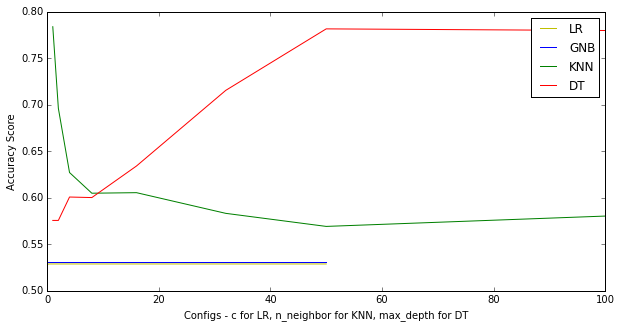

0.784084259801
['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request']


In [136]:
features = ['requester_account_age_in_days_at_request']

train_age = []
cv_age = []
test_age = []

for i in range(len(train_up_labels)):
    train_age.append((train_up[i].get(features[0])))

for i in range(len(cv_up_labels)):
    cv_age.append((cv_up[i].get(features[0])))

for i in range(len(test_up_labels)):
    test_age.append((test_up[i].get(features[0])))

feature = 'requester_days_since_first_post_on_raop_at_request'

# myan: initialize
best_score = 0
best_numerical_classifier=None
best_models = dict()
best_scores = dict()

train_data_plus, cv_data_plus, test_data_plus, best_numerical_classifier, best_score, best_models, best_scores, features = evaluate_new_feature(train_up, 
                    train_up_labels, train_age, cv_up, cv_up_labels, cv_age, test_up, test_up_labels, test_age, feature, 
                    prev_best_classifier=best_numerical_classifier, 
                    prev_best_score=best_score,
                    prev_best_models=best_models,
                    prev_best_scores=best_scores,
                    current_features=features)

print features

requester_number_of_comments_at_request



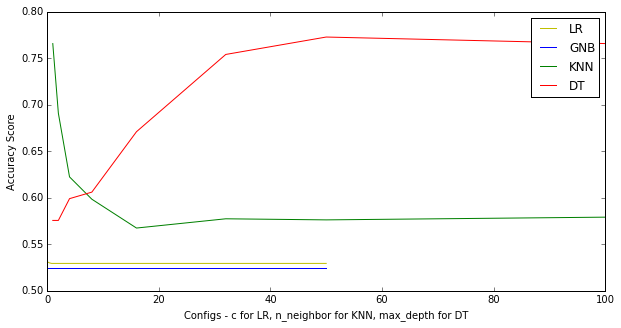

0.784084259801
['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request']


In [137]:
feature = 'requester_number_of_comments_at_request'
print feature + "\n"
train_data_plus, cv_data_plus, test_data_plus, best_numerical_classifier, best_score, best_models, best_scores, features = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus, cv_up, cv_up_labels, cv_data_plus, test_up, test_up_labels, test_data_plus, feature, 
                    prev_best_classifier=best_numerical_classifier, 
                    prev_best_score=best_score,
                    prev_best_models=best_models,
                    prev_best_scores=best_scores,
                    current_features=features)
print features

requester_upvotes_minus_downvotes_at_request



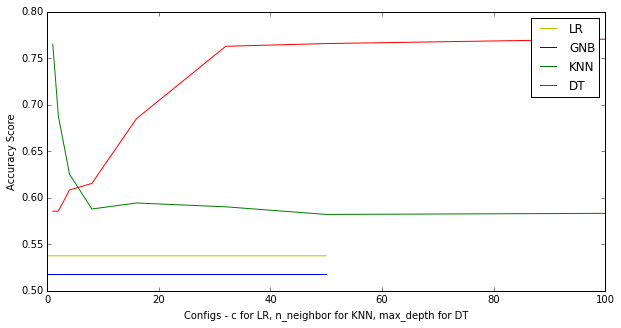

0.784084259801
['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request']


In [138]:
feature = 'requester_upvotes_minus_downvotes_at_request'
print feature + "\n"
train_data_plus, cv_data_plus, test_data_plus, best_numerical_classifier, best_score, best_models, best_scores, features = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus, cv_up, cv_up_labels, cv_data_plus, test_up, test_up_labels, test_data_plus, feature, 
                    prev_best_classifier=best_numerical_classifier, 
                    prev_best_score=best_score,
                    prev_best_models=best_models,
                    prev_best_scores=best_scores,
                    current_features=features)
print features

requester_number_of_subreddits_at_request



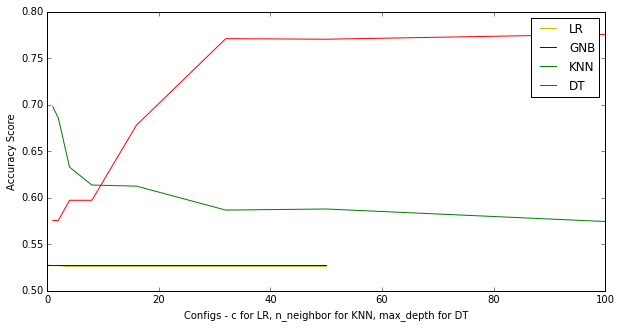

0.784084259801
['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request']


In [139]:
feature = 'requester_number_of_subreddits_at_request'

print feature + "\n"
train_data_plus, cv_data_plus, test_data_plus, best_numerical_classifier, best_score, best_models, best_scores, features = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus, cv_up, cv_up_labels, cv_data_plus, test_up, test_up_labels, test_data_plus, feature, 
                    prev_best_classifier=best_numerical_classifier, 
                    prev_best_score=best_score,
                    prev_best_models=best_models,
                    prev_best_scores=best_scores,
                    current_features=features)
print features

### Observe a big performance gain by using the timestamp information

unix_timestamp_of_request_utc



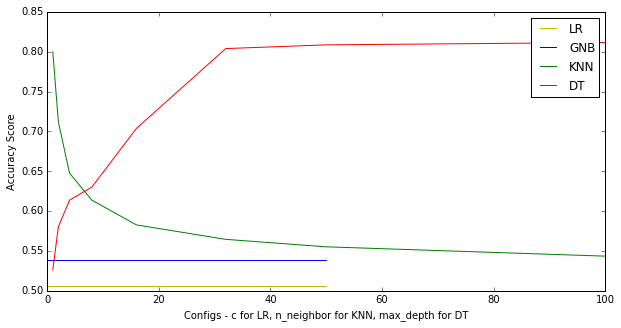

0.811585722645
['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request', 'unix_timestamp_of_request_utc']


In [140]:
feature = 'unix_timestamp_of_request_utc'

print feature + "\n"
train_data_plus, cv_data_plus, test_data_plus, best_numerical_classifier, best_score, best_models, best_scores, features = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus, cv_up, cv_up_labels, cv_data_plus, test_up, test_up_labels, test_data_plus, feature, 
                    prev_best_classifier=best_numerical_classifier, 
                    prev_best_score=best_score,
                    prev_best_models=best_models,
                    prev_best_scores=best_scores,
                    current_features=features)
print features

### Test if the length of the text matters

length_of_text



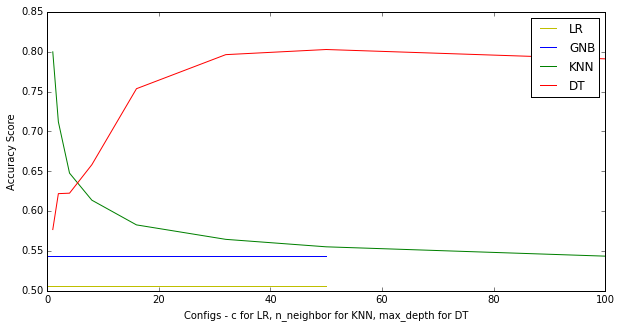

0.811585722645
['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request', 'unix_timestamp_of_request_utc']


In [141]:
for entry in train_up:
    entry['length_of_text'] = len(entry['request_text_edit_aware'].split())    
    
for entry in cv_up:
    entry['length_of_text'] = len(entry['request_text_edit_aware'].split())        
    
for entry in test_up:
    entry['length_of_text'] = len(entry['request_text_edit_aware'].split())        


feature = 'length_of_text'

print feature + "\n"
train_data_plus, cv_data_plus, test_data_plus, best_numerical_classifier, best_score, best_models, best_scores, features = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus, cv_up, cv_up_labels, cv_data_plus, test_up, test_up_labels, test_data_plus, feature, 
                    prev_best_classifier=best_numerical_classifier, 
                    prev_best_score=best_score,
                    prev_best_models=best_models,
                    prev_best_scores=best_scores,
                    current_features=features)
train_data_plus.shape
print features

### Test if http links help

has_link



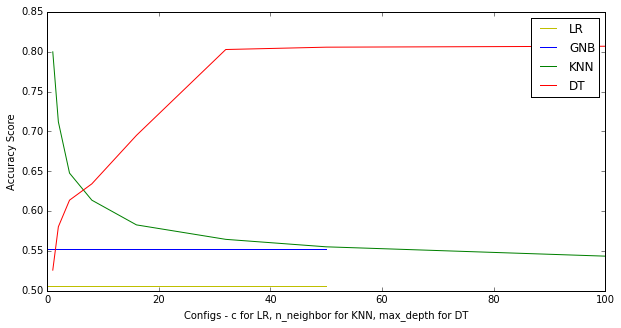

0.811585722645
['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request', 'unix_timestamp_of_request_utc']


In [142]:
for entry in train_up:
    entry['has_link'] = 'http:' in entry['request_text_edit_aware'] or 'https:' in entry['request_text_edit_aware']
    
for entry in cv_up:
    entry['has_link'] = 'http:' in entry['request_text_edit_aware'] or 'https:' in entry['request_text_edit_aware']
    
for entry in test_up:
    entry['has_link'] = 'http:' in entry['request_text_edit_aware'] or 'https:' in entry['request_text_edit_aware']


feature = 'has_link'

print feature + "\n"
train_data_plus, cv_data_plus, test_data_plus, best_numerical_classifier, best_score, best_models, best_scores, features = evaluate_new_feature(train_up, 
                    train_up_labels, train_data_plus, cv_up, cv_up_labels, cv_data_plus, test_up, test_up_labels, test_data_plus, feature, 
                    prev_best_classifier=best_numerical_classifier, 
                    prev_best_score=best_score,
                    prev_best_models=best_models,
                    prev_best_scores=best_scores,
                    current_features=features)
print features

# Ready to Make a Submission Now

We are now at the stage where we feel ready to put everything back together. 

For text we have this many features: 2215

 For the title we have this many features :2282
request_text_edit_aware

For KNN cv :

             precision    recall  f1-score   support

        0.0       0.70      0.83      0.76       895
        1.0       0.76      0.61      0.68       815

avg / total       0.73      0.73      0.72      1710

For KNN test :

             precision    recall  f1-score   support

        0.0       0.68      0.83      0.75       844
        1.0       0.79      0.62      0.69       865

avg / total       0.73      0.72      0.72      1709

request_title

For KNN cv :

             precision    recall  f1-score   support

        0.0       0.73      0.79      0.76       895
        1.0       0.75      0.68      0.71       815

avg / total       0.74      0.74      0.74      1710

For KNN test :

             precision    recall  f1-score   support

        0.0       0.71      0.79      0.75       844
        1.0       0.77      0.69      0.72       865

avg

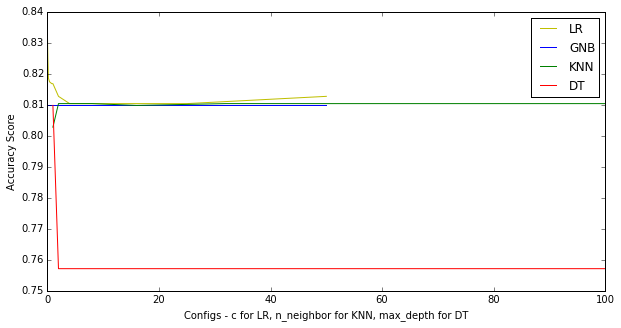

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
0.01
0.833820947923


In [99]:
#make four models (one from title, test, subreddit, and numerical) and see if ensemble is better

print "For text we have this many features: " + str(len(ValuableVocab_Text[4]))
print "\n For the title we have this many features :" + str(len(ValuableVocab_Title[5]))

#get the data again
train_data_text = []
cv_data_text = []
test_data_text = []
train_data_title = []
cv_data_title = []
test_data_title = []
train_data_sr = []
cv_data_sr = []
test_data_sr = []
    
feature = 'request_text_edit_aware'    
for i in range(len(train_up_labels)):
    train_data_text.append(train_up[i].get(feature))

for i in range(len(cv_up_labels)):
    cv_data_text.append(cv_up[i].get(feature))

for i in range(len(test_up_labels)):
    test_data_text.append(test_up[i].get(feature))

feature = 'request_title'    
for i in range(len(train_up_labels)):
    train_data_title.append(train_up[i].get(feature))

for i in range(len(cv_up_labels)):
    cv_data_title.append(cv_up[i].get(feature))

for i in range(len(test_up_labels)):
    test_data_title.append(test_up[i].get(feature))

feature = 'requester_subreddits_at_request'
for i in range(len(train_up_labels)):
    train_data_sr.append(string.join(train_up[i].get(feature)," "))
for i in range(len(cv_up_labels)):
    cv_data_sr.append(string.join(cv_up[i].get(feature)," "))
for i in range(len(test_up_labels)):
    test_data_sr.append(string.join(test_up[i].get(feature)," "))    

#vectorize the title with the right number of features
vec_train_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_train_data_title = vec_train_title.fit_transform(train_data_title)

vec_cv_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_cv_data_title = vec_cv_title.fit_transform(cv_data_title)

vec_test_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_test_data_title = vec_test_title.fit_transform(test_data_title)

#vectorize the text with the right number of features
vec_train_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_train_data_text = vec_train_text.fit_transform(train_data_text)

vec_cv_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_cv_data_text = vec_cv_text.fit_transform(cv_data_text)

vec_test_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_test_data_text = vec_test_text.fit_transform(test_data_text)

#vectorize the subreddits with the right number of features

vec_train_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_train_data_sr = vec_train_sr.fit_transform(train_data_sr)

vec_cv_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_cv_data_sr = vec_cv_sr.fit_transform(cv_data_sr)

vec_test_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_test_data_sr = vec_test_sr.fit_transform(test_data_sr)


######REQUEST TEXT EDIT AWARE#######
feature = 'request_text_edit_aware'
print feature + "\n"

KNN_train_text = KNeighborsClassifier(n_neighbors = 2)
KNN_train_text.fit(tokenized_train_data_text,train_up_labels)

cv_pred = KNN_train_text.predict(tokenized_cv_data_text)

print "For KNN cv :\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = KNN_train_text.predict(tokenized_test_data_text)

print "For KNN test :\n"
print(classification_report(test_up_labels, test_pred))


######REQUEST TITLE#######
feature = 'request_title'
print feature + "\n"

KNN_train_title = KNeighborsClassifier(n_neighbors = 2)
KNN_train_title.fit(tokenized_train_data_title,train_up_labels)

cv_pred = KNN_train_title.predict(tokenized_cv_data_title)

print "For KNN cv :\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = KNN_train_title.predict(tokenized_test_data_title)

print "For KNN test :\n"
print(classification_report(test_up_labels, test_pred))
    
######SUBREDDITS SUBSCRIBED#########

feature = 'requester_subreddits_at_request'
print feature + "\n"

LR_train_subreddit = LogisticRegression(C = 8)
LR_train_subreddit.fit(tokenized_train_data_sr,train_up_labels)

cv_pred = LR_train_subreddit.predict(tokenized_cv_data_sr)

print "For LR cv :\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = LR_train_subreddit.predict(tokenized_test_data_sr)

print "For LR test :\n"
print(classification_report(test_up_labels, test_pred))


#######NUMERICAL PROPERTIES#########
best_numerical_classifier.fit(train_data_plus,train_up_labels)

cv_pred = best_numerical_classifier.predict(cv_data_plus)

print "\nFor DT cv with max depth of 32:\n"
print(classification_report(cv_up_labels, cv_pred))

test_pred = best_numerical_classifier.predict(test_data_plus)

print "The test results are:\n"
print(classification_report(test_up_labels, test_pred))

#####ENSEMBLE VIA PROBABILITY #######
train_text_probability = KNN_train_text.predict_proba(tokenized_train_data_text)
cv_text_probability = KNN_train_text.predict_proba(tokenized_cv_data_text)
test_text_probability = KNN_train_text.predict_proba(tokenized_test_data_text)

train_title_probability = KNN_train_title.predict_proba(tokenized_train_data_title)
cv_title_probability = KNN_train_title.predict_proba(tokenized_cv_data_title)
test_title_probability = KNN_train_title.predict_proba(tokenized_test_data_title)

train_sr_probability = LR_train_subreddit.predict_proba(tokenized_train_data_sr)
cv_sr_probability = LR_train_subreddit.predict_proba(tokenized_cv_data_sr)
test_sr_probability = LR_train_subreddit.predict_proba(tokenized_test_data_sr)

train_num_probability = best_numerical_classifier.predict_proba(train_data_plus)
cv_num_probability = best_numerical_classifier.predict_proba(cv_data_plus)
test_num_probability = best_numerical_classifier.predict_proba(test_data_plus)

train_ensemble_prob = np.c_[train_text_probability,train_title_probability,
                                 train_sr_probability,train_num_probability]
cv_ensemble_prob = np.c_[cv_text_probability,cv_title_probability,
                              cv_sr_probability,cv_num_probability]
test_ensemble_prob = np.c_[test_text_probability,test_title_probability,
                                test_sr_probability,test_num_probability]

print "Ensemble models!!!\n\n"

best_clf, best_config, best_score, _, _ = find_optim_model_numerical(train_ensemble_prob, 
                           train_up_labels, cv_ensemble_prob, cv_up_labels, 
                           test_ensemble_prob, test_up_labels)

print best_clf
print best_config
print best_score

## Final Version

In [ ]:
#create predictions for Kaggle
#order of data:
#text stuff
#requester_account_age_in_days_at_request
#requester_days_since_first_post_on_raop_at_request
#requester_number_of_comments_at_request
#requester_upvotes_minus_downvotes_at_request
#requester_number_of_subreddits_at_request
#unix_timestamp_of_request_utc
#hyperlink exist

#READ

test_data = pd.read_json('data/test.json')
test_data_text = test_data.request_text_edit_aware
test_data_title = test_data.request_title
test_data_subreddits = test_data.requester_subreddits_at_request

test_data_age = test_data.requester_account_age_in_days_at_request
test_data_days = test_data.requester_days_since_first_post_on_raop_at_request
test_data_comm = test_data.requester_number_of_comments_at_request
test_data_umd = test_data.requester_upvotes_minus_downvotes_at_request
test_data_utc = test_data.unix_timestamp_of_request_utc

#TOKENIZE
vec_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_test_data_text = vec_text.fit_transform(test_data_text)

vec_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_test_data_title = vec_title.fit_transform(test_data_title)

st_tmp = []

for i in range(len(test_data_subreddits)):
    st_tmp.append(string.join(test_data_subreddits[i]," "))

vec_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_test_data_sr = vec_sr.fit_transform(st_tmp)

#AGG NUMERICAL FEATURES
num_feat = np.c_[test_data_age, 
                 test_data_days, 
                 test_data_comm, 
                 test_data_umd, 
                 test_data_utc]

#PREDICT
text_prob = KNN_train_text.predict_proba(tokenized_test_data_text)
title_prob = KNN_train_title.predict_proba(tokenized_test_data_title)
sr_prob = LR_train_subreddit.predict_proba(tokenized_test_data_sr)
num_prob = clf.predict_proba(num_feat)

submission_ensemble_prob = np.c_[text_prob, title_prob, sr_prob, num_prob]

best_clf.fit(train_ensemble_prob, train_up_labels) # myan: set this programatically
test_pred = best_clf.predict(submission_ensemble_prob)

#OUTPUT
predictions = pd.DataFrame()
predictions['request_id'] = test_data.request_id
predictions['requester_received_pizza'] = test_pred
predictions = predictions.set_index('request_id')

predictions.to_csv('Pizza_Learning_Submission_Single_Ensembling.csv')

## Final Version - With More Ensembling

Another idea we had was to see if further ensembling helps improve the accuracy. Implementation below:
1. Both **find_optim_model_textual** and **find_optim_model_numerical** output the best classifiers under each class (i.e. LR, KNN, NB, and DT);
2. In the above section, we just picked the best out of the four (a.k.a best-of-best). Instead, here, we will train all four and use all to predict probabilities;
3. We use the trained best ensemble classifier to combine the predicted probabilities of all classifier.

This improved accuracy on test data from 0.83 to 0.87, while accuracy on leader board stays unchanged. Perhaps further ensembling will generalize better to unseen data as it has less reliance on the caliberation of a specific classifier. 

In [100]:
def train_predictors(train_data, train_labels, predictors):
    for _, predictor in predictors.items():
        predictor.fit(train_data, train_labels)
    return predictors

def make_predict_probability_matrix(data_predictors):
    prob_matrix = None
    for (data, predictors) in data_predictors:            
        for _, predictor in predictors.items():
            if prob_matrix is None:
                prob_matrix = predictor.predict_proba(data)
            else:
                prob_matrix = np.c_[prob_matrix, predictor.predict_proba(data)]
    return prob_matrix

In [102]:
trained_models_text = train_predictors(tokenized_train_data_text,train_up_labels, best_models_text)
trained_models_title = train_predictors(tokenized_train_data_title,train_up_labels, best_models_title)
trained_models_sr = train_predictors(tokenized_train_data_sr,train_up_labels, best_models_sr)
trained_models_numerical = train_predictors(train_data_plus, train_up_labels, best_models)


train_ensemble_prob2 = make_predict_probability_matrix([(tokenized_train_data_text, trained_models_text), 
                                                            (tokenized_train_data_title, trained_models_title),
                                                            (tokenized_train_data_sr, trained_models_sr),
                                                            (train_data_plus, trained_models_numerical)])

cv_ensemble_prob2 = make_predict_probability_matrix([(tokenized_cv_data_text, trained_models_text), 
                                                            (tokenized_cv_data_title, trained_models_title),
                                                            (tokenized_cv_data_sr, trained_models_sr),
                                                            (cv_data_plus, trained_models_numerical)])

test_ensemble_prob2 = make_predict_probability_matrix([(tokenized_test_data_text, trained_models_text), 
                                                            (tokenized_test_data_title, trained_models_title),
                                                            (tokenized_test_data_sr, trained_models_sr),
                                                            (test_data_plus, trained_models_numerical)])


best_clf2, best_config2, best_score2, _, _ = find_optim_model_numerical(train_ensemble_prob2, 
                           train_up_labels, cv_ensemble_prob2, cv_up_labels, 
                           test_ensemble_prob2, test_up_labels)

print best_clf2
print best_config2
print best_score2

In [104]:
test_data = pd.read_json('data/test.json')

#TOKENIZE
test_data_text = test_data.request_text_edit_aware
vec_text = CountVectorizer(vocabulary=ValuableVocab_Text[4],preprocessor=better_preprocessor)
tokenized_test_data_text = vec_text.fit_transform(test_data_text)

test_data_title = test_data.request_title
vec_title = CountVectorizer(vocabulary=ValuableVocab_Title[5],preprocessor=better_preprocessor)
tokenized_test_data_title = vec_title.fit_transform(test_data_title)

test_data_subreddits = test_data.requester_subreddits_at_request
st_tmp = []
for i in range(len(test_data_subreddits)):
    st_tmp.append(string.join(test_data_subreddits[i]," "))
vec_sr = CountVectorizer(vocabulary=ValuableVocab_Subreddits[6],preprocessor=better_preprocessor)
tokenized_test_data_sr = vec_sr.fit_transform(st_tmp)

test_numerical_data = test_data[features].values


submission_ensemble_prob = make_predict_probability_matrix([(tokenized_test_data_text, trained_models_text), 
                                                            (tokenized_test_data_title, trained_models_title),
                                                            (tokenized_test_data_sr, trained_models_sr),
                                                            (test_numerical_data, trained_models_numerical)])
best_clf2.fit(train_ensemble_prob2, train_up_labels) # myan: set this programatically
test_pred = best_clf2.predict(submission_ensemble_prob)

#OUTPUT
predictions = pd.DataFrame()
predictions['request_id'] = test_data.request_id
predictions['requester_received_pizza'] = test_pred
predictions = predictions.set_index('request_id')

predictions.to_csv('Pizza_Learning_Submission_Multi_Ensembling.csv')